In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
from mpl_toolkits.mplot3d import Axes3D
import pickle
import sys
import time 
import os
import matplotlib.pyplot as plt
import numpy as np
from pyquaternion import Quaternion
from transforms3d.euler import mat2euler
import mpl_toolkits.mplot3d as a3


In [2]:

def rotplot(R, currentAxes=None):
    """
    Plots the orientation of a 3x3 rotation matrix R.
    """
    lx = 3.0
    ly = 1.5
    lz = 1.0

    x = 0.5 * np.array([
        [+lx, -lx, +lx, -lx, +lx, -lx, +lx, -lx],
        [+ly, +ly, -ly, -ly, +ly, +ly, -ly, -ly],
        [+lz, +lz, +lz, +lz, -lz, -lz, -lz, -lz]
    ])

    xp = np.dot(R, x)
    ifront = np.array([0, 2, 6, 4, 0])
    iback = np.array([1, 3, 7, 5, 1])
    itop = np.array([0, 1, 3, 2, 0])
    ibottom = np.array([4, 5, 7, 6, 4])

    if currentAxes:
        ax = currentAxes
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')  # Use add_subplot instead of gca

    ax.plot(xp[0, itop], xp[1, itop], xp[2, itop], 'k-')
    ax.plot(xp[0, ibottom], xp[1, ibottom], xp[2, ibottom], 'k-')

    rectangleFront = a3.Poly3DCollection([list(zip(xp[0, ifront], xp[1, ifront], xp[2, ifront]))])
    rectangleFront.set_facecolor('Blue')
    ax.add_collection(rectangleFront)

    rectangleBack = a3.Poly3DCollection([list(zip(xp[0, iback], xp[1, iback], xp[2, iback]))])
    rectangleBack.set_facecolor('Red')
    ax.add_collection(rectangleBack)

    ax.set_xlim3d(-2, 2)
    ax.set_ylim3d(-2, 2)
    ax.set_zlim3d(-2, 2)

    return ax




In [3]:
def tic():
  return time.time()
def toc(tstart, nm=""):
  print('%s took: %s sec.\n' % (nm,(time.time() - tstart)))

def read_data(fname):
  d = []
  with open(fname, 'rb') as f:
    if sys.version_info[0] < 3:
      d = pickle.load(f)
    else:
      d = pickle.load(f, encoding='latin1')  # needed for python 3
  return d


print("Current Working Directory:", os.getcwd())

dataset="1"
cfile = "../data/cam/cam" + dataset + ".p"
ifile = "../data/imu/imuRaw" + dataset + ".p"
vfile = "../data/vicon/viconRot" + dataset + ".p"

ts = tic()
camd = read_data(cfile)
imud = read_data(ifile)
vicd = read_data(vfile)
toc(ts,"Data import")

Current Working Directory: c:\Users\kvuon\OneDrive\Documents\Personal\UCSD\ECE 276a\ECE276A_PR1\code
Data import took: 3.9523518085479736 sec.



In [4]:
rots = vicd['rots']
victs = vicd['ts'].squeeze()
vict = victs-victs[0]
print(vict.shape,rots.shape)

(5561,) (3, 3, 5561)


In [5]:
camts = camd['ts'].squeeze()
cam = camd['cam']
camt = camts-camts[0]
print(camts.shape,cam.shape)

(1685,) (240, 320, 3, 1685)


In [6]:
# Initialize an array to store indices of the closest matches in victs for each camts entry
closest_indices = np.zeros(len(camts), dtype=int)

# For each timestamp in camts, find the closest timestamp in victs
for i, cam_time in enumerate(camts):
    closest_indices[i] = np.argmin(np.abs(victs - cam_time))

# Extract the corresponding entries in victs and rots
synced_victs = victs[closest_indices]
synced_rots = rots[:, :, closest_indices]

# Print shapes to verify
print("Synced victs shape:", synced_victs.shape)
print("Synced rots shape:", synced_rots.shape)

rots = synced_rots
victs = synced_victs

Synced victs shape: (1685,)
Synced rots shape: (3, 3, 1685)


In [148]:
# def project_image_to_sphere(image):
#     """
#     Projects a 240x320 RGB image onto a sphere with a given latitude and longitude range.

#     :param image: NumPy array of shape (240, 320, 3) with values in [0,1] or [0,255]
#     """
#     import numpy as np
#     import matplotlib.pyplot as plt

#     # Ensure image values are normalized to [0,1]
#     if image.dtype == np.uint8:
#         image = image / 255.0

#     # Define image dimensions
#     width, height = 320, 240

#     # Define the longitude and latitude bounds
#     lon_min, lon_max = np.radians([-30, 30])  # Convert degrees to radians
#     lat_min, lat_max = np.radians([-22.5, 22.5])

#     # Create a grid of pixel coordinates
#     u = np.linspace(0, width - 1, width)
#     v = np.linspace(0, height - 1, height)
#     U, V = np.meshgrid(u, v)

#     # Normalize pixel coordinates to range [0,1]
#     s = U / (width - 1)
#     t = V / (height - 1)

#     # Convert to longitude (theta) and latitude (phi)
#     theta = lon_min + s * (lon_max - lon_min)  # Longitude
#     phi = lat_max - t * (lat_max - lat_min)    # Latitude

#     # Convert to Cartesian coordinates (unit sphere)
#     x = np.cos(phi) * np.cos(theta)
#     y = np.cos(phi) * np.sin(theta)
#     z = np.sin(phi)

#     # Transpose the image to match the expected (width, height) format
#     image = np.transpose(image, (1, 0, 2))  # Now shape is (320, 240, 3)

#     # Flatten image to match the projected points
#     colors = image.reshape(-1, 3)

#     # Generate sphere wireframe for reference
#     u_sphere = np.linspace(0, 2 * np.pi, 100)
#     v_sphere = np.linspace(-np.pi / 2, np.pi / 2, 50)
#     xs = np.outer(np.cos(u_sphere), np.cos(v_sphere))
#     ys = np.outer(np.sin(u_sphere), np.cos(v_sphere))
#     zs = np.outer(np.ones(np.size(u_sphere)), np.sin(v_sphere))

#     # Plot the projection with the image colors
#     fig = plt.figure(figsize=(8, 6))
#     ax = fig.add_subplot(111, projection='3d')
#     ax.scatter(x, y, z, s=1, c=colors, marker='o', alpha=0.7)

#     # Plot sphere wireframe
#     ax.plot_wireframe(xs, ys, zs, color="gray", alpha=0.3)

#     # Labels
#     ax.set_xlabel("X")
#     ax.set_ylabel("Y")
#     ax.set_zlabel("Z")
#     ax.set_title("Projected Image onto Sphere")

#     plt.show()

# # Example usage (assuming 'image' is a 240x320x3 NumPy array)
# # project_image_to_sphere(image)


In [165]:
def sph2cart(image):
    """
    Projects a 240x320 RGB image onto a sphere with a given latitude and longitude range.

    :param image: NumPy array of shape (240, 320, 3) with values in [0,1] or [0,255]
    """
    # Ensure image values are normalized to [0,1]
    # Define image dimensions
    width, height = 320, 240

    # Define the longitude and latitude bounds
    lon_min, lon_max = np.radians([-30, 30])  # Convert degrees to radians
    lat_min, lat_max = np.radians([-22.5, 22.5])

    # Create a grid of pixel coordinates
    u = np.linspace(0, width - 1, width)
    v = np.linspace(0, height - 1, height)
    U, V = np.meshgrid(u, v)

    # Normalize pixel coordinates to range [0,1]
    s = U / (width - 1)
    t = V / (height - 1)

    # Convert to longitude (theta) and latitude (phi)
    theta = lon_min + s * (lon_max - lon_min)  # Longitude
    phi = lat_max - t * (lat_max - lat_min)    # Latitude

    # Convert to Cartesian coordinates (unit sphere)
    x = np.cos(phi) * np.cos(theta)
    y = np.cos(phi) * np.sin(theta)
    z = np.sin(phi)

    return np.array([x,y,z])

In [149]:
def project_image_to_sphere(image):
    """
    Projects a 240x320 RGB image onto a sphere with a given latitude and longitude range.

    :param image: NumPy array of shape (240, 320, 3) with values in [0,1] or [0,255]
    """
    # Transpose the image to match the expected (width, height) format
    image = np.transpose(image, (1, 0, 2))  # Now shape is (320, 240, 3)

    # Flatten image to match the projected points
    colors = image.reshape(-1, 3)

    # Generate sphere wireframe for reference
    u_sphere = np.linspace(0, 2 * np.pi, 100)
    v_sphere = np.linspace(-np.pi / 2, np.pi / 2, 50)
    xs = np.outer(np.cos(u_sphere), np.cos(v_sphere))
    ys = np.outer(np.sin(u_sphere), np.cos(v_sphere))
    zs = np.outer(np.ones(np.size(u_sphere)), np.sin(v_sphere))

    # Plot the projection with the image colors
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, s=1, c=colors, marker='o', alpha=0.7)

    # Plot sphere wireframe
    ax.plot_wireframe(xs, ys, zs, color="gray", alpha=0.3)

    # Labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Projected Image onto Sphere")

    plt.show()

# Example usage (assuming 'image' is a 240x320x3 NumPy array)
# project_image_to_sphere(image)


In [179]:
cartcoords = sph2cart(cam)
print(cartcoords.shape)
cartcoords = np.transpose(cartcoords,(1, 2, 0))
cartcoords.shape

(3, 240, 320)


(240, 320, 3)

In [180]:
# Reshape cartesian_coords to (320, 240, 3, 1) for broadcasting
cartesian_coords = cartcoords[..., np.newaxis]  # Shape: (320, 240, 3, 1)

print(cartesian_coords.shape)
# Transpose rotation_matrices to (1685, 3, 3) for batch broadcasting
rotation_matrices = np.transpose(rots, (2, 0, 1))  # Shape: (1685, 3, 3)

# Perform the matrix multiplication
# Broadcast (1685, 3, 3) with (320, 240, 3, 1)
rotated_coords = np.matmul(rotation_matrices[:, np.newaxis, np.newaxis, :, :], cartesian_coords)  # Shape: (1685, 320, 240, 3, 1)

# Remove the last dimension (from shape (1685, 320, 240, 3, 1))
rotated_coords = rotated_coords.squeeze(-1)  # Shape: (1685, 320, 240, 3)

# Reorder dimensions to (320, 240, 3, 1685)
rotated_coords = rotated_coords.transpose(1, 2, 3, 0)  # Shape: (320, 240, 3, 1685)

print(rotated_coords.shape)  # Should be (320, 240, 3, 1685)


(240, 320, 3, 1)
(240, 320, 3, 1685)


In [181]:
rotated_coords[0,0,2,0]

firstframe = rotated_coords[:,:,:,0]
firstframe[160,120,:]
firstrgb = cam[:,:,:,0]
# Convert firstrgb to float before dividing
firstrgb = firstrgb.astype(np.float64)  # Convert to float
firstrgb /= 255.0  # Normalize RGB values to the range [0, 1]

firstframeflat = firstframe.reshape(-1,3)
firstframergb = firstrgb.reshape(-1,3)
firstframergb

array([[0.8       , 0.57647059, 0.59215686],
       [0.79215686, 0.55294118, 0.57254902],
       [0.78039216, 0.54509804, 0.56470588],
       ...,
       [0.63921569, 0.42745098, 0.45098039],
       [0.63137255, 0.41568627, 0.42745098],
       [0.63921569, 0.38823529, 0.38039216]])

In [199]:
rotated_coords.shape

(240, 320, 3, 1685)

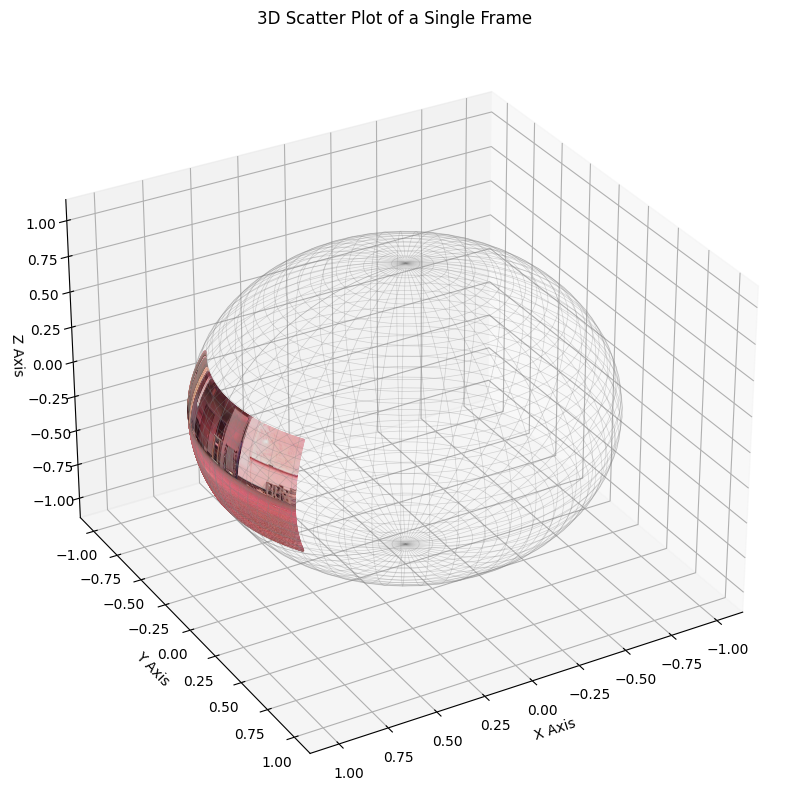

In [189]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')

ax.scatter(
    firstframeflat[:,0],
    firstframeflat[:,1],
    firstframeflat[:,2],
    c=firstframergb,
    marker='o',
    s=1    
)

# Add labels and title
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")

# Generate a sphere wireframe for reference
u = np.linspace(0, 2 * np.pi, 50)  # Longitude angles
v = np.linspace(-np.pi / 2, np.pi / 2, 50)  # Latitude angles
xs = np.outer(np.cos(u), np.cos(v))
ys = np.outer(np.sin(u), np.cos(v))
zs = np.outer(np.ones(np.size(u)), np.sin(v))

# Plot the sphere wireframe
ax.plot_wireframe(xs, ys, zs, color="gray", alpha=0.3, linewidth=0.5)

# Set labels and title
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("3D Scatter Plot of a Single Frame")

# Adjust view
ax.view_init(elev=30, azim=60)

# Show the plot
plt.show()

In [194]:
def visualize_superimposed(rotated_coords, cam, frame_step=1):
    """
    Visualize all frames in a single 3D scatter plot, superimposed, with a wireframe sphere.

    Parameters:
    - rotated_coords: 4D array (320, 240, 3, T) of XYZ coordinates.
    - cam: 4D array (320, 240, 3, T) of RGB colors.
    - frame_step: Step size to skip frames for visualization (default is 1).
    """
    num_frames = rotated_coords.shape[3]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Loop through frames and add their points to the scatter plot
    for t in range(0, num_frames, frame_step):
        # Extract XYZ coordinates and RGB colors for frame `t`
        xyz_points = rotated_coords[:, :, :, t].reshape(-1, 3)  # Shape: (320*240, 3)
        rgb_colors = cam[:, :, :, t].reshape(-1, 3) / 255.0  # Normalize RGB to [0,1]

        # Add points to the scatter plot
        ax.scatter(
            xyz_points[:, 0], xyz_points[:, 1], xyz_points[:, 2],
            c=rgb_colors, marker='o', s=1, alpha=0.5  # Add transparency
        )

    # Generate a sphere wireframe for reference
    u = np.linspace(0, 2 * np.pi, 50)  # Longitude angles
    v = np.linspace(-np.pi / 2, np.pi / 2, 50)  # Latitude angles
    xs = np.outer(np.cos(u), np.cos(v))
    ys = np.outer(np.sin(u), np.cos(v))
    zs = np.outer(np.ones(np.size(u)), np.sin(v))
    
    # Plot the sphere wireframe
    ax.plot_wireframe(xs, ys, zs, color="gray", alpha=0.3, linewidth=0.5)

    # Set labels and title
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("3D Visualization of All Frames Superimposed with Sphere Wireframe")

    # Adjust view
    ax.view_init(elev=30, azim=60)

    # Show the plot
    plt.show()


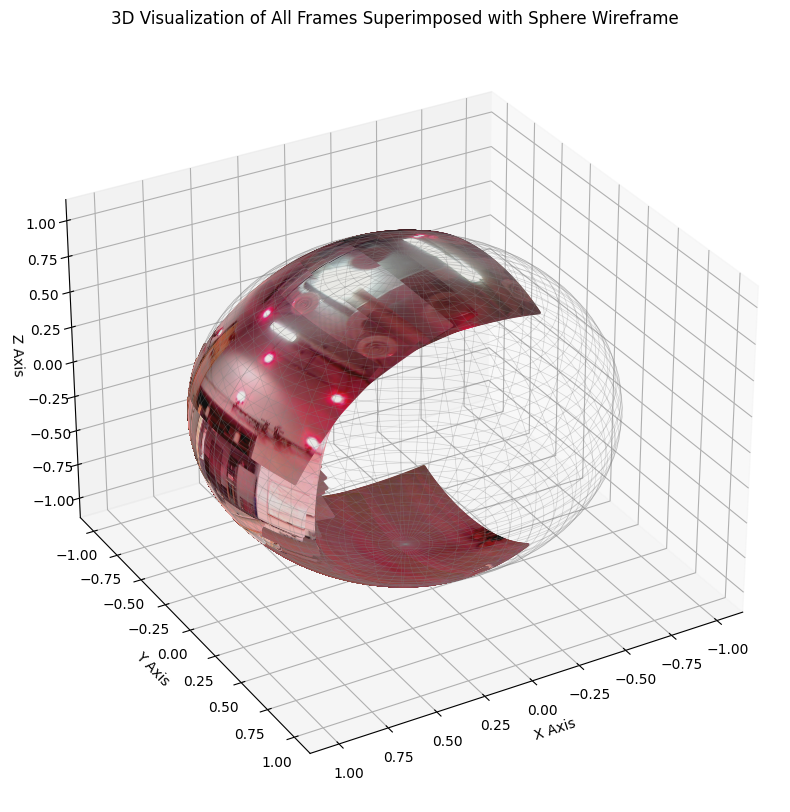

In [196]:
# visualize_superimposed(rotated_coords,cam,frame_step=10)

In [211]:
def accumulate_images_on_sphere(rotated_coords, cam, sphere_size=(1000, 2000, 3)):
    """
    Projects all images onto a common spherical grid and accumulates colors efficiently.

    Parameters:
    - rotated_coords: NumPy array of shape (240, 320, 3, 1685) containing XYZ coordinates.
    - cam: NumPy array of shape (240, 320, 3, 1685) containing RGB colors.
    - sphere_size: Tuple (lat_size, lon_size, 3) specifying the output spherical grid resolution.

    Returns:
    - sphere_image: NumPy array of shape (1000, 2000, 3) representing the accumulated images.
    """
    lat_size, lon_size, _ = sphere_size

    # Initialize the sphere image
    sphere_image = np.zeros((lat_size, lon_size, 3))
    
    # Flatten the input data for vectorized processing
    xyz_points = rotated_coords.reshape(-1, 3)  # Shape (240*320*1685, 3)
    rgb_colors = cam.reshape(-1, 3) / 255.0     # Normalize and flatten

    # Convert Cartesian (x, y, z) to Spherical (theta, phi)
    theta = np.arctan2(xyz_points[:, 1], xyz_points[:, 0])  # Longitude (-π, π)
    phi = np.arcsin(np.clip(xyz_points[:, 2], -1, 1))       # Latitude (-π/2, π/2)

    # Normalize theta and phi to pixel indices
    lon_idx = ((theta + np.pi) / (2 * np.pi) * lon_size).astype(int)  # Range [0, lon_size-1]
    lat_idx = ((phi + np.pi / 2) / np.pi * lat_size).astype(int)      # Range [0, lat_size-1]

    # Ensure indices are within valid bounds
    lon_idx = np.clip(lon_idx, 0, lon_size - 1)
    lat_idx = np.clip(lat_idx, 0, lat_size - 1)

    # Vectorized accumulation using numpy advanced indexing
    sphere_image[lat_idx, lon_idx] = rgb_colors

    return sphere_image



In [212]:
sphere_image = accumulate_images_on_sphere(rotated_coords, cam)
